In [4]:
import warnings 
warnings.filterwarnings('ignore')
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import sys
sys.path.append('.')
sys.path.append('..')
import yaml 
import argparse
import traceback
import time
import torch

from model.models import STSSL
from model.trainer import Trainer
from lib.dataloader import get_dataloader
from lib.utils import (
    init_seed,
    get_model_params,
    load_graph, 
)

In [8]:
parser = argparse.ArgumentParser()
parser.add_argument('--config_filename', default='D:\\omer\\ST-SSL\\configs\\Careeem.yaml', 
                type=str, help='the configuration to use')
args, unknown = parser.parse_known_args()
print(f'Starting experiment with configurations in {args.config_filename}...')
time.sleep(3)
configs = yaml.load(
    open(args.config_filename), 
    Loader=yaml.FullLoader
)

args = argparse.Namespace(**configs)


Starting experiment with configurations in D:\omer\ST-SSL\configs\Careeem.yaml...


In [9]:
init_seed(args.seed)
if not torch.cuda.is_available():
    args.device = 'cpu'

## load dataset
dataloader = get_dataloader(
    data_dir=args.data_dir, 
    dataset=args.dataset, 
    batch_size=args.batch_size, 
    test_batch_size=args.test_batch_size,
)
graph = load_graph(args.graph_file, device=args.device)
args.num_nodes = len(graph)

## init model and set optimizer
model = STSSL(args).to(args.device)
model_parameters = get_model_params([model])
optimizer = torch.optim.Adam(
    params=model_parameters, 
    lr=args.lr_init, 
    eps=1.0e-8, 
    weight_decay=0, 
    amsgrad=False
)

X.shape: torch.Size([1503, 12, 285, 1]), Y.shape: torch.Size([1503, 1, 285, 1])
X.shape: torch.Size([215, 12, 285, 1]), Y.shape: torch.Size([215, 1, 285, 1])
X.shape: torch.Size([430, 12, 285, 1]), Y.shape: torch.Size([430, 1, 285, 1])


In [11]:
## start training
trainer = Trainer(
    model=model, 
    optimizer=optimizer, 
    dataloader=dataloader,
    graph=graph, 
    args=args
)

2024-01-30 09:32:56: Experiment log path in: D:\omer\ST-SSL\experiments\Careem_linear\20240130-093256
2024-01-30 09:32:56: Experiment configs are: Namespace(seed=31, device='cuda', mode='train', best_path='None', debug=False, data_dir='data', dataset='Careem_linear', input_length=12, batch_size=64, val_batch_size=64, test_batch_size=1, graph_file='data/Careem/adj_mx.npz', d_input=1, d_output=1, d_model=64, dropout=0.2, percent=0.1, shm_temp=0.5, nmb_prototype=2, yita=1, epochs=100, lr_init=0.001, early_stop=True, early_stop_patience=150, grad_norm=True, max_grad_norm=5, use_dwa=True, temp=4, num_nodes=285, log_dir='D:\\omer\\ST-SSL\\experiments\\Careem_linear\\20240130-093256')


Creat Log File in:  D:\omer\ST-SSL\experiments\Careem_linear\20240130-093256\run.log


In [46]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from lib.metrics import test_metrics


def test(model, dataloader, scaler, graph, logger, args):
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(dataloader):
            repr1, repr2 = model(data, graph)                
            pred_output = model.predict(repr1, repr2)

            y_true.append(target)
            y_pred.append(pred_output)
    y_true = scaler.inverse_transform(torch.cat(y_true, dim=0)).cpu().numpy()
    y_pred = scaler.inverse_transform(torch.cat(y_pred, dim=0)).cpu().numpy()

    test_results = []
    # inflow
    mae, mape = test_metrics(y_pred[..., 0], y_true[..., 0])
    logger.info("test, MAE: {:.2f}, test MAPE: {:.4f}%".format(mae, mape*100))
    test_results.append([mae, mape])
    
    print("y_true.shape: ", y_true.shape, "y_pred.shape: ", y_pred.shape)

    # Plotting
    plt.figure(figsize=(10, 5))
    
    ## to plot all regions 
    # plt.plot(y_true[..., 0].flatten()[3000:4000], label='True Values')
    # plt.plot(y_pred[..., 0].flatten()[3000:4000], label='Predictions')
    ## to plot summed up regions
    plt.plot(np.sum(y_true[:, :, :, :], axis=2).flatten()
             , label='True Values')
    plt.plot(np.sum(y_pred[:, :, :, :], axis=2).flatten(), label='Predictions')
    
    plt.title("Comparison of True and Predicted Values")
    plt.xlabel("Sample")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

    # outflow 
    # mae, mape = test_metrics(y_pred[..., 1], y_true[..., 1])
    # logger.info("OUTFLOW, MAE: {:.2f}, MAPE: {:.4f}%".format(mae, mape*100))
    # test_results.append([mae, mape]) 

    return np.stack(test_results, axis=0)


2024-01-30 10:15:44: test, MAE: 6.32, test MAPE: 31.3048%


y_true.shape:  (430, 1, 285, 1) y_pred.shape:  (430, 1, 285, 1)


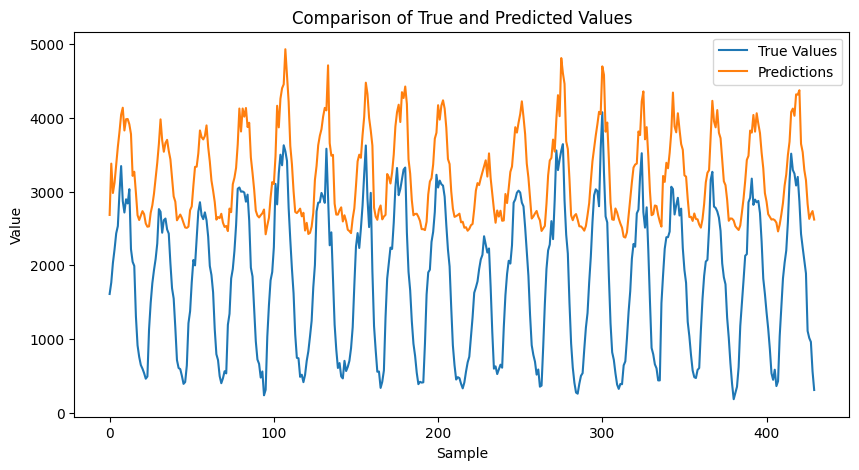

array([[6.324061  , 0.31304774]], dtype=float32)

In [47]:
test(model, dataloader['test'], dataloader['scaler'],
            graph, trainer.logger, trainer.args)

In [48]:

def test_rolling(model, dataloader, scaler, graph, logger, args):
    model.eval()
    y_pred = []
    y_true = []
    prediction_buffer = None  # Buffer to hold predictions for future time steps

    # torch.Size([batch_size=1, time_steps=19, no.ofnodes=285, features=1]) data shape
    # torch.Size([1, 1, 285, 1]) pred_output shape
    # print("len(dataloader): ", len(dataloader))
    with torch.no_grad():
        for idx, (data, target) in enumerate(dataloader):
            # print(f"idx: {idx}, data.shape: {data.shape}, target.shape: {target.shape}")
            # Update data with predictions from buffer
            if prediction_buffer is not None:
                for t in range(len(prediction_buffer)):
                    if t <= data.shape[1]:  # Ensure the time step exists in the data
                        # print("data.shape: ", data.shape, "data[:, t, :, :].shape: ", data[:, t, :, :].shape, "prediction_buffer[t].shape: ", prediction_buffer[t].shape)
                        # print(f"for data at index {idx} replacing data[:, {t}, :, :] with prediction_buffer[{t}]")
                        data[:, t, :, :] = prediction_buffer[t].squeeze(1)

            repr1, repr2 = model(data, graph)
            pred_output = model.predict(repr1, repr2)

            y_true.append(target)
            y_pred.append(pred_output)

            # Update the prediction buffer
            if prediction_buffer is None:
                prediction_buffer = [pred_output]
            else:
                prediction_buffer.insert(0, pred_output)  ## insert at 0th index
                prediction_buffer = prediction_buffer[:data.shape[1]]  # Keep buffer size same as the number of time steps

    y_true = scaler.inverse_transform(torch.cat(y_true, dim=0)).cpu().numpy()
    y_pred = scaler.inverse_transform(torch.cat(y_pred, dim=0)).cpu().numpy()

    test_results = []

    print("y_true.shape: ", y_true.shape, "y_pred.shape: ", y_pred.shape)

    # Plotting
    plt.figure(figsize=(10, 5))
    
    ## to plot all regions 
    # plt.plot(y_true[..., 0].flatten()[3000:4000], label='True Values')
    # plt.plot(y_pred[..., 0].flatten()[3000:4000], label='Predictions')
    ## to plot summed up regions
    plt.plot(np.sum(y_true[:, :, :, :], axis=2).flatten(), label='True Values')
    plt.plot(np.sum(y_pred[:, :, :, :], axis=2).flatten(), label='Predictions')
    
    plt.title("Comparison of True and Predicted Values")
    plt.xlabel("Sample")
    plt.ylabel("Value")
    plt.legend()
    plt.show()
    
    # inflow
    mae, mape = test_metrics(y_pred[..., 0], y_true[..., 0])
    logger.info("rolling, MAE: {:.2f}, rolling MAPE: {:.4f}%".format(mae, mape*100))
    test_results.append([mae, mape])

    return np.stack(test_results, axis=0)

y_true.shape:  (430, 1, 285, 1) y_pred.shape:  (430, 1, 285, 1)


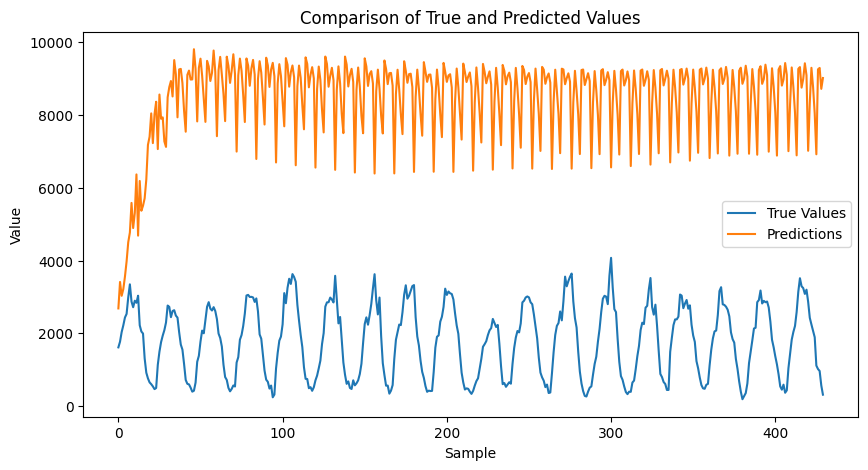

2024-01-30 10:15:53: rolling, MAE: 33.49, rolling MAPE: 217.6308%


array([[33.49241  ,  2.1763084]], dtype=float32)

In [49]:
test_rolling(model, dataloader['test'], dataloader['scaler'],
            graph, trainer.logger, trainer.args)

In [45]:
args.best_path = r"D:\omer\ST-SSL\experiments\Careem_linear\20240130-100155\best_model.pth"
state_dict = torch.load(
                args.best_path,
                map_location=torch.device(args.device)
            )
model.load_state_dict(state_dict['model'])
print("Load saved model")
results = trainer.test(model, dataloader['test'], dataloader['scaler'],
            graph, trainer.logger, trainer.args)
results_rolling = trainer.test_rolling(model, dataloader['test'], dataloader['scaler'],
            graph, trainer.logger, trainer.args)

Load saved model


2024-01-30 10:15:32: test, MAE: 6.32, test MAPE: 31.3048%
2024-01-30 10:15:35: rolling, MAE: 33.49, rolling MAPE: 217.6308%


In [ ]:
def val_metrics(pred, logger):
    # pdb.set_trace()
    test_num_each = [5464, 5373, 27014, 4239, 3936, 6258, 10474, 6273,
                     10512, 6667, 22131, 4661, 8855, 14047, 28896, 4209]
    test_num_snippet = [43, 42, 212, 34, 31, 49, 82, 50, 83, 53, 173, 37, 70, 110, 226, 33]
    # test_num_rem = [88, 125, 6, 15, 96, 114, 106, 1, 16, 11, 115, 53, 23, 95, 96, 113]

    mean_weighted_f1 = 0.0
    mean_unweighted_f1 = 0.0
    mean_global_f1 = 0.0
    mean_balanced_acc = 0.0
    each_wf1 = []
    each_unf1 = []
    each_gf1 = []
    each_bacc = []

    test_labels_pth = ''

    for i in range(16):
        predi = pred[sum(test_num_snippet[:i]): sum(test_num_snippet[:i+1])]
        predi = [p for p in predi for _ in range(128)]
        predi = predi[:test_num_each[i]]

        tl_pth = test_labels_pth + '/test_video_' + str(i).zfill(4) + '.csv'
        ls = np.array(pd.read_csv(tl_pth, usecols=['frame_label']))

        label = []
        predict = []
        for idx, l in enumerate(ls):
            if not np.isnan(l):
                label.append(int(l))
                predict.append(predi[idx])

        # pdb.set_trace()
        mean_weighted_f1 += f1_score(label, predict, average='weighted')/16.0
        mean_unweighted_f1 += f1_score(label, predict, average='macro') / 16.0
        mean_global_f1 += f1_score(label, predict, average='micro') / 16.0
        mean_balanced_acc += balanced_accuracy_score(label, predict) / 16.0

        each_wf1.append(f1_score(label, predict, average='weighted'))
        each_unf1.append(f1_score(label, predict, average='macro'))
        each_gf1.append(f1_score(label, predict, average='micro'))
        each_bacc.append(balanced_accuracy_score(label, predict))
        # print('video: ', i, 'label: ', label, 'predict: ', predict)

    logger.info('wf1: {}'.format(each_wf1))
    logger.info('unf1:{}'.format(each_unf1))
    logger.info('gf1:{}'.format(each_gf1))
    logger.info('bacc:{}'.format(each_bacc))


    return mean_weighted_f1, mean_unweighted_f1, mean_global_f1, mean_balanced_acc